# Index

### 1. Dealing with categorical features
    1.1. Bucketing bins
    1.2. and One-Hot encoding
    1.3 string integet -> identity, vocabulary_file if don't know go with hash bucket
    
### 2. Feature transformation
    2.1 log
   
    2.2 feature expentions, PolynomialFeatures, extraction
    
    2.3 Scaling or normalizing features within a range 
    
### 3. Feature crossing - (long, lat)

### 4. Row aggregation, group by

    4.1 Moving averages with panda df

### 5. Embedding works with everything space reduction

### 6. Simple model improved after feature engineering.


In [1]:
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import pandas as pd
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
import matplotlib.pyplot as plt
from collections import OrderedDict

In [2]:
# Project constants
LEARN_SIZE = 50
POLY_DEGREE = 2
LEARNING_RATE = 0.001
DISPLAY_STEP = 200
NUM_STEPS = 3000
PRINT_LIMIT = 5

In [3]:
# Immediate execution
tf.enable_eager_execution()
tfe = tf.contrib.eager


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



# Load dataset

From Google Machine Learning crash course

In [4]:
housing_df = pd.read_csv("https://storage.googleapis.com/ml_universities/california_housing_train.csv", sep=",")

Let's look over the dataset

In [5]:
housing_df.head(PRINT_LIMIT)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


In [6]:
housing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000
mean,-119.562108,35.625225,28.589353,2643.664412,539.410824,1429.573941,501.221941,3.883578,207300.912353
std,2.005166,2.137340,12.586937,2179.947071,421.499452,1147.852959,384.520841,1.908157,115983.764387
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.790000,33.930000,18.000000,1462.000000,297.000000,790.000000,282.000000,2.566375,119400.000000
50%,-118.490000,34.250000,29.000000,2127.000000,434.000000,1167.000000,409.000000,3.544600,180400.000000
75%,-118.000000,37.720000,37.000000,3151.250000,648.250000,1721.000000,605.250000,4.767000,265000.000000
max,-114.310000,41.950000,52.000000,37937.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


It seems reasonable to evaluate also the dataset features. The dataset is very abundant, so we may limit the data only for the evaluation purposes.

In [7]:
housing_df = housing_df[:LEARN_SIZE]

We can continue with the Tensorflow data processing now. We may prepare the uniform routine to convert any numeric feature to the Feature Column. This routine also can use predefined transformation function.

In [8]:
# TODO Delete!!!
def prepare_feature_numeric_column(feature, transformer=None):
    if transformer:
        feature_column = tf.feature_column.numeric_column(feature, normalizer_fn=transformer)
    else:
        feature_column = tf.feature_column.numeric_column(feature)
    feature_tensor = {feature: tf.convert_to_tensor(housing_df[feature])}
    return tf.feature_column.input_layer(feature_tensor, feature_column)

# 1. Dealing with categorical features
1.1. Bucketing bins and One-Hot encoding
1.2

Some numeric values perform better in the categorized form. For example, we can convert 'Housing median age' field into bucketing form. Such operation results in the one-hot-encoded matrix with the parameters separated into predefined bins.

In [9]:
feature_column = tf.feature_column.numeric_column('housing_median_age')
feature = {'housing_median_age': tf.convert_to_tensor(housing_df['housing_median_age'])}

bucketized_column = tf.feature_column.bucketized_column(
    source_column = feature_column,
    boundaries = [10, 20, 30, 40])

net_age_bucket = tf.feature_column.input_layer(feature, bucketized_column)
print(net_age_bucket.numpy()[:PRINT_LIMIT])

[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]


In [10]:
# one hot encoding no bins

Also a more condensed representation would help in our further calculations. This one-hot-decoding gives us a flat category (rank of current bin).

In [11]:
bucket_index = tf.reshape(tf.cast(tf.argmax(net_age_bucket, axis=1), tf.float32), [-1, 1])
print(bucket_index.numpy()[:PRINT_LIMIT])

[[1.]
 [1.]
 [1.]
 [1.]
 [2.]]


# 2. Feature transformation
## 2.1 log
Tensorflow helps us to make a direct conversion of feature data during the import. For example, we obtain a log transformed data directly.

In [12]:
#todo do not use function
def log_transformer(x):
    return tf.cast(tf.log(x), dtype=tf.float32)

net_age_log = prepare_feature_numeric_column('housing_median_age', log_transformer)
print(net_age_log.numpy()[:PRINT_LIMIT])

[[2.7080503]
 [2.944439 ]
 [2.8332133]
 [2.6390574]
 [2.9957323]]


## 2.2 feature 
Data conversion may include a popular polynomial conversion. We will get the polynomially transformed (squared) data in the next cell.

In [13]:
#todo put multiple polinomials, show the input and output together,plot it
def poly_transformer(x):
    return tf.cast(tf.pow(x, POLY_DEGREE), dtype=tf.float32)

net_age_poly = prepare_feature_numeric_column('housing_median_age', poly_transformer)
print(net_age_poly.numpy()[:PRINT_LIMIT])

[[225.]
 [361.]
 [289.]
 [196.]
 [400.]]


## 2.3 Scaling or normalizing features within a range 
Normalization is one of the most popular data transformation methods. Tensorflow helps us to prepare a feature column with zero mean and uniform standard deviation easily.

In [14]:
# use tf scaling function
val_mean = housing_df['housing_median_age'].mean()
val_std = housing_df['housing_median_age'].std()

def scaler(x):
    return (tf.cast(x, dtype=tf.float32) - val_mean) / val_std

net_age_scale = prepare_feature_numeric_column('housing_median_age', scaler)
print(net_age_scale.numpy()[:PRINT_LIMIT])

[[-0.9863035 ]
 [-0.5338707 ]
 [-0.7600871 ]
 [-1.0994117 ]
 [-0.42076248]]


# 3. Feature crossing 
Need to mention also more complex data processing methods like feature crossing. They could help us to combine similar variables  for a further simultaneous processing.

In [15]:
def get_quantile_based_boundaries(feature_values, num_buckets):
    boundaries = np.arange(1.0, num_buckets) / num_buckets
    quantiles = feature_values.quantile(boundaries)
    return [quantiles[q] for q in quantiles.keys()]

In [16]:
# X*Y^-1

In [17]:
housing_df['rooms_per_person'] = housing_df['total_rooms'] / housing_df['population']
housing_df['rooms_per_person'].head(PRINT_LIMIT)

0    5.529064
1    6.775908
2    2.162162
3    2.914563
4    2.330128
Name: rooms_per_person, dtype: float64

# 4. Row aggregation, group by,
A detailed dataset evaluation may include grouping of some features. What if we want to estimate average dataset values related to the same housing mean age?

In [18]:
# mean on axis 1
# use case or remove

In [19]:
housing_df.groupby(['housing_median_age']).mean().head(PRINT_LIMIT)

,longitude,latitude,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_person
housing_median_age,,,,,,,,,
11.0,-115.510,32.6800,2872.0,610.0,2644.0,581.0,2.625000,72700.0,1.086233
13.0,-115.500,32.7500,330.0,72.0,822.0,64.0,3.410700,142500.0,0.401460
14.0,-114.970,33.2300,1388.5,303.5,691.0,243.5,2.564600,77150.0,2.193152
15.0,-114.850,33.3625,2779.5,614.0,1049.5,361.5,1.973425,68600.0,3.345913
16.0,-114.995,33.1900,2438.5,498.5,1457.5,504.5,4.467750,116400.0,1.949361


## 4.1 Moving averages with panda df
Otherwise we may change the dataset representation by preparing the moving average to smooth possible divagations of variable variability.

In [20]:
#remove sorting
housing_df_sorted = housing_df.sort_values('housing_median_age')
housing_df_sorted['h_m_age_rolling'] = housing_df_sorted['housing_median_age'].rolling(5, min_periods=1).mean()
housing_df_sorted.head(PRINT_LIMIT)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_person,h_m_age_rolling
49,-115.51,32.68,11.0,2872.0,610.0,2644.0,581.0,2.6250,72700.0,1.086233,11.000000
43,-115.50,32.75,13.0,330.0,72.0,822.0,64.0,3.4107,142500.0,0.401460,12.000000
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0,2.914563,12.666667
27,-115.37,32.82,14.0,1276.0,270.0,867.0,261.0,1.9375,80900.0,1.471742,13.000000
38,-115.48,32.68,15.0,3414.0,666.0,2097.0,622.0,2.3319,91200.0,1.628040,13.400000


#  5. Embedding

In [21]:
#todo explain the size of 50 vs 10
longitude_bucket_feature_column = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column('longitude'),
    boundaries=get_quantile_based_boundaries(housing_df['longitude'], 10))

latitude_bucket_feature_column = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column('latitude'),
    boundaries=get_quantile_based_boundaries(housing_df['latitude'], 10))

crossed_lat_lon_feature_column = tf.feature_column.crossed_column(
    [longitude_bucket_feature_column, latitude_bucket_feature_column], 50)
crossed_column=tf.feature_column.indicator_column(crossed_lat_lon_feature_column)

features = {'longitude': tf.convert_to_tensor(housing_df['longitude']), 'latitude': tf.convert_to_tensor(housing_df['latitude'])}
feature_columns=[crossed_column]
tf.feature_column.input_layer(features,feature_columns)



<tf.Tensor: id=174, shape=(50, 50), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [40]:
tf.feature_column.embedding_column?

In [23]:
#
tf.tables_initializer()

#todo explain the size of 50 vs 10
longitude_bucket_feature_column = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column('longitude'),
    boundaries=get_quantile_based_boundaries(housing_df['longitude'], 10))

latitude_bucket_feature_column = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column('latitude'),
    boundaries=get_quantile_based_boundaries(housing_df['latitude'], 10))

crossed_column = tf.feature_column.crossed_column(
    [longitude_bucket_feature_column, latitude_bucket_feature_column], 50)

embedding_dimensions=int(50**0.25)

# Represent the categorical column as an embedding column.
# This means creating an embedding vector lookup table with one element for each category.
embedding_column = tf.feature_column.embedding_column(
    categorical_column=crossed_column,
    dimension=embedding_dimensions)

features = {'longitude': tf.convert_to_tensor(housing_df['longitude']), 'latitude': tf.convert_to_tensor(housing_df['latitude'])}
feature_columns=[embedding_column]
tf.feature_column.input_layer(features,feature_columns)

<tf.Tensor: id=336, shape=(50, 2), dtype=float32, numpy=
array([[-0.39916804,  0.7382097 ],
       [-0.39916804,  0.7382097 ],
       [-0.45139673,  0.0510562 ],
       [-0.45139673,  0.0510562 ],
       [-0.9637922 , -0.4054328 ],
       [-0.45139673,  0.0510562 ],
       [-0.45139673,  0.0510562 ],
       [-0.45139673,  0.0510562 ],
       [-0.45139673,  0.0510562 ],
       [-0.45139673,  0.0510562 ],
       [-0.45139673,  0.0510562 ],
       [-0.42639452,  0.2340586 ],
       [ 0.5371241 , -0.33556747],
       [ 0.5371241 , -0.33556747],
       [ 0.2944763 , -0.64874464],
       [-1.107216  ,  0.07231083],
       [-1.107216  ,  0.07231083],
       [ 0.4566305 , -0.64787686],
       [ 0.6559161 ,  0.6768343 ],
       [ 0.5685392 ,  0.45155483],
       [-0.41420764,  0.63762295],
       [-0.41420764,  0.63762295],
       [-0.16306353,  1.2384467 ],
       [-0.16306353,  1.2384467 ],
       [ 1.1762332 , -0.05374845],
       [-0.39916804,  0.7382097 ],
       [-0.39916804,  0.7382097 ]

In [24]:
embedding_column

EmbeddingColumn(categorical_column=CrossedColumn(keys=(BucketizedColumn(source_column=NumericColumn(key='longitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(-115.5, -115.49, -115.40299999999999, -115.374, -115.27, -114.676, -114.644, -114.6, -114.579)), BucketizedColumn(source_column=NumericColumn(key='latitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(32.68, 32.758, 32.81, 32.82, 33.055, 33.51, 33.61, 33.716, 34.577999999999996))), hash_bucket_size=50, hash_key=None), dimension=2, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x000002107DA4A7B8>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True)

# 6. simple model improved after feature engineering.
Let's make some tests with our processed data. Does the feature processing actually improves the prediction?

First we need to define a really simple linear regression using Tensorflow.

In [32]:
# estimator
# Definition of linear equation
a = tfe.Variable(np.random.randn())
b = tfe.Variable(np.random.randn())

def linear_regression(inputs):
    return inputs * a + b

In [33]:
# Regression objective as minimization of error
def mean_square_fn(model_fn, inputs, labels):
    n_samples = int(tf.size(labels))
    return tf.reduce_sum(tf.pow(model_fn(inputs) - labels, 2)) / (2 * n_samples)

In [34]:
# Training optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=LEARNING_RATE)
grad = tfe.implicit_gradients(mean_square_fn)

In [35]:
# Main regression routine
def make_regression(x, y):
    for step in range(NUM_STEPS):
        optimizer.apply_gradients(grad(linear_regression, x, y))
        if (step + 1) % DISPLAY_STEP == 0 or step == 0:
            print("Epoch:", '%04d' % (step + 1), "cost=",
                  "{:.9f}".format(mean_square_fn(linear_regression, x, y)),
                  "a=", a.numpy(), "b=", b.numpy())
    return a, b

In [36]:
# Plot results
def make_plot(x, y):
    plt.plot(x, y, 'ro', label='Original')
    plt.plot(x, np.array(a * x + b), label='Fitted')
    plt.legend()
    plt.show()

What if we want to estimate median income using the source median housing age?

Epoch: 0001 cost= 0.868670702 a= 0.059423007 b= 0.09744411
Epoch: 0200 cost= 0.743745744 a= 0.07612521 b= 0.15019244
Epoch: 0400 cost= 0.730679989 a= 0.0742293 b= 0.20127653
Epoch: 0600 cost= 0.718225121 a= 0.07237824 b= 0.25115222
Epoch: 0800 cost= 0.706352174 a= 0.07057094 b= 0.2998487
Epoch: 1000 cost= 0.695034325 a= 0.068806395 b= 0.3473932
Epoch: 1200 cost= 0.684245527 a= 0.06708358 b= 0.39381328
Epoch: 1400 cost= 0.673960924 a= 0.06540152 b= 0.43913552
Epoch: 1600 cost= 0.664157093 a= 0.06375923 b= 0.4833858
Epoch: 1800 cost= 0.654811561 a= 0.062155787 b= 0.5265896
Epoch: 2000 cost= 0.645902872 a= 0.060590267 b= 0.5687716
Epoch: 2200 cost= 0.637410462 a= 0.059061773 b= 0.60995585
Epoch: 2400 cost= 0.629315197 a= 0.057569437 b= 0.650166
Epoch: 2600 cost= 0.621598184 a= 0.056112383 b= 0.6894253
Epoch: 2800 cost= 0.614241898 a= 0.054689795 b= 0.727756
Epoch: 3000 cost= 0.607229471 a= 0.053300854 b= 0.76518023


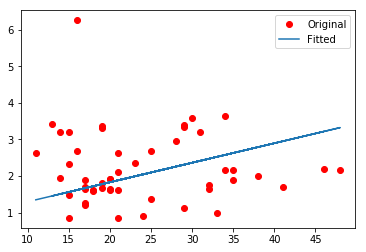

In [37]:
age_net = prepare_feature_numeric_column('housing_median_age')
income_net = prepare_feature_numeric_column('median_income')
a, b = make_regression(age_net, income_net)
make_plot(age_net, income_net)

Scaling is also a good try to improve the accuracy, but unfortunately not in this case...

Epoch: 0001 cost= 1.516047955 a= 0.053213637 b= 0.7666294
Epoch: 0200 cost= 1.170572639 a= 0.03745359 b= 1.0279899
Epoch: 0400 cost= 0.937621355 a= 0.024428219 b= 1.2431387
Epoch: 0600 cost= 0.781495869 a= 0.013722212 b= 1.4192702
Epoch: 0800 cost= 0.676859438 a= 0.00492259 b= 1.5634606
Epoch: 1000 cost= 0.606731951 a= -0.0023101107 b= 1.6815009
Epoch: 1200 cost= 0.559732378 a= -0.00825491 b= 1.778134
Epoch: 1400 cost= 0.528232396 a= -0.0131411385 b= 1.8572437
Epoch: 1600 cost= 0.507121027 a= -0.017157294 b= 1.9220065
Epoch: 1800 cost= 0.492972106 a= -0.020458305 b= 1.9750245
Epoch: 2000 cost= 0.483489305 a= -0.02317152 b= 2.018428
Epoch: 2200 cost= 0.477133840 a= -0.0254016 b= 2.0539606
Epoch: 2400 cost= 0.472874492 a= -0.027234575 b= 2.0830483
Epoch: 2600 cost= 0.470019907 a= -0.028741172 b= 2.1068602
Epoch: 2800 cost= 0.468106717 a= -0.029979482 b= 2.126354
Epoch: 3000 cost= 0.466824412 a= -0.030997291 b= 2.1423135


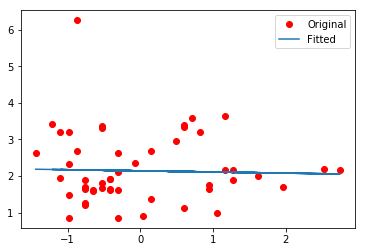

In [38]:
a, b = make_regression(net_age_scale, income_net)
make_plot(net_age_scale, income_net)

Bit of uniformity seems also not impressive in this case.

Epoch: 0001 cost= 0.472005337 a= -0.03077873 b= 2.1424444
Epoch: 0200 cost= 0.466567546 a= -0.0049370476 b= 2.1605928
Epoch: 0400 cost= 0.465754092 a= 0.00250943 b= 2.1704326
Epoch: 0600 cost= 0.465510130 a= 0.0035740098 b= 2.1772451
Epoch: 0800 cost= 0.465343297 a= 0.0024811474 b= 2.1829042
Epoch: 1000 cost= 0.465194196 a= 0.00068904454 b= 2.1880605
Epoch: 1200 cost= 0.465055317 a= -0.0012999416 b= 2.1929414
Epoch: 1400 cost= 0.464925051 a= -0.003313656 b= 2.197631
Epoch: 1600 cost= 0.464802980 a= -0.005294091 b= 2.2021575
Epoch: 1800 cost= 0.464688540 a= -0.0072224606 b= 2.206537
Epoch: 2000 cost= 0.464581102 a= -0.009093543 b= 2.2107775
Epoch: 2200 cost= 0.464480430 a= -0.010906777 b= 2.2148814
Epoch: 2400 cost= 0.464386076 a= -0.012663253 b= 2.218856
Epoch: 2600 cost= 0.464297414 a= -0.014364393 b= 2.2227077
Epoch: 2800 cost= 0.464214414 a= -0.016011873 b= 2.2264342
Epoch: 3000 cost= 0.464136362 a= -0.017607404 b= 2.2300472


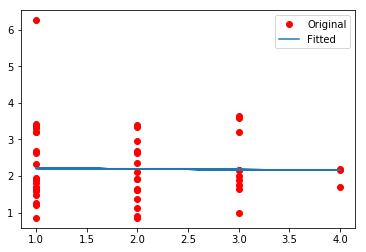

In [39]:
a, b = make_regression(bucket_index, income_net)
make_plot(bucket_index, income_net)